In [ ]:
from expert_data import*

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
random.seed(0)

expert_agent,_=train_expert_agent(env)

n_episode = 1
print("Sampling expert data...")
expert_s, expert_a = sample_expert_data(env,expert_agent,n_episode)

n_samples = 30
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

print(f"Collected {len(expert_s)} expert state-action pairs")

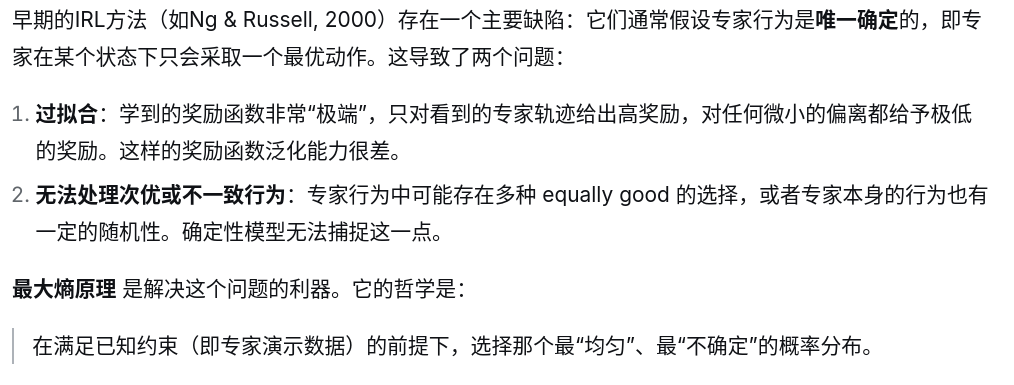  
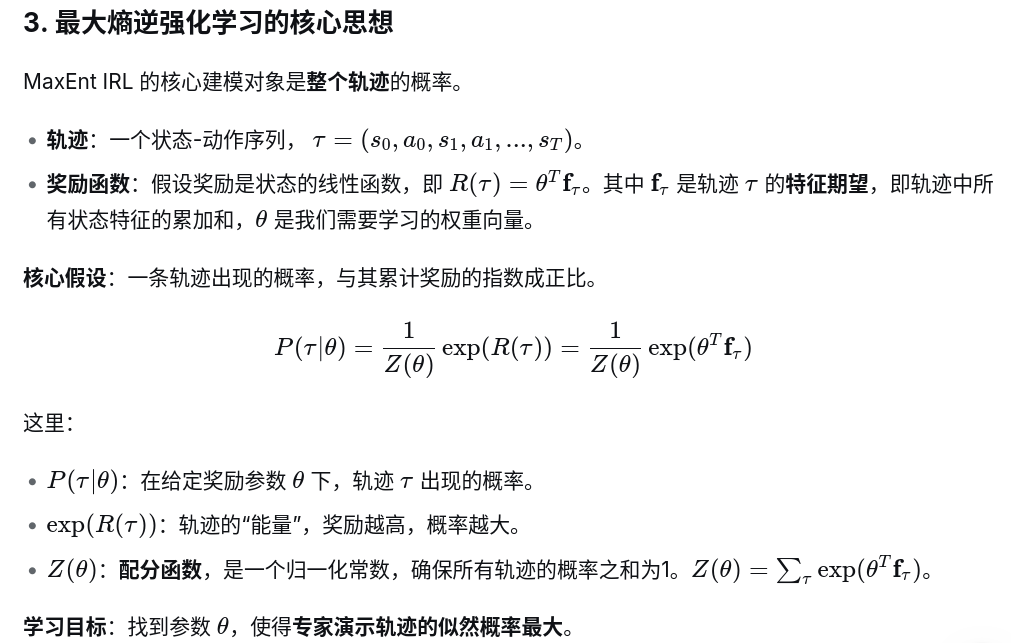  
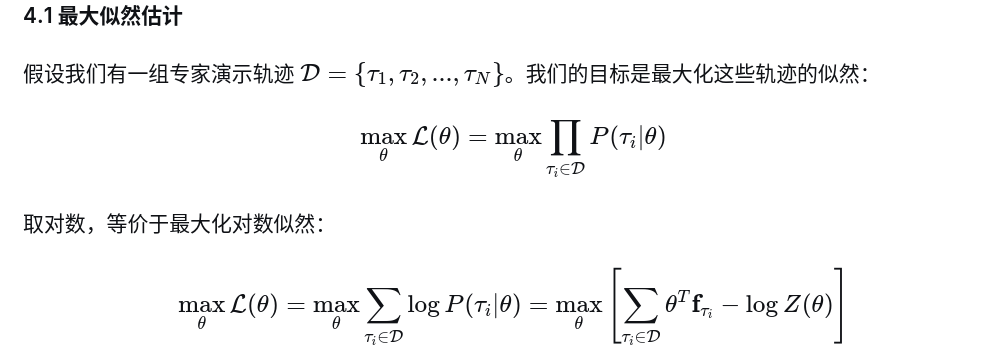  

使用最大似然估计就是计算交叉熵  

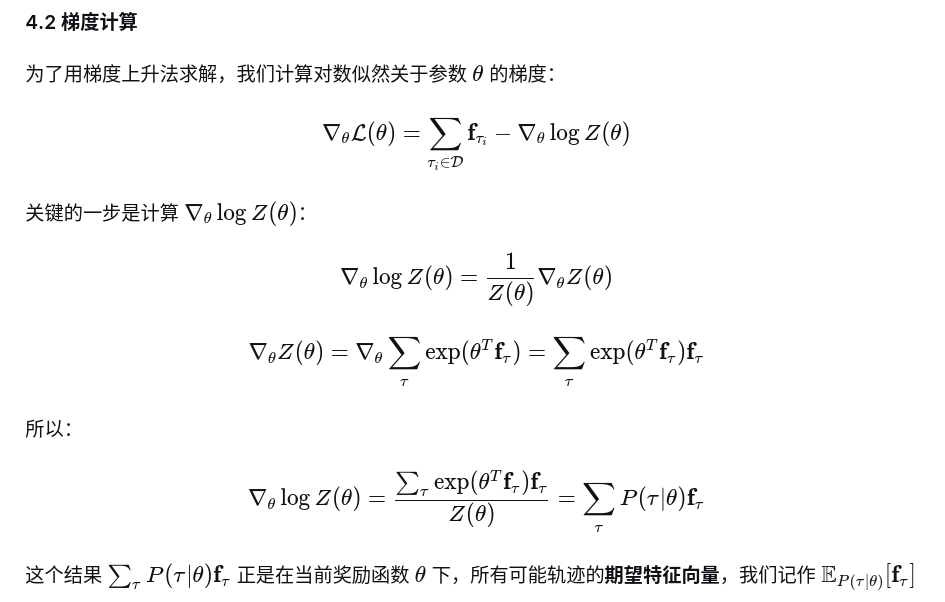  

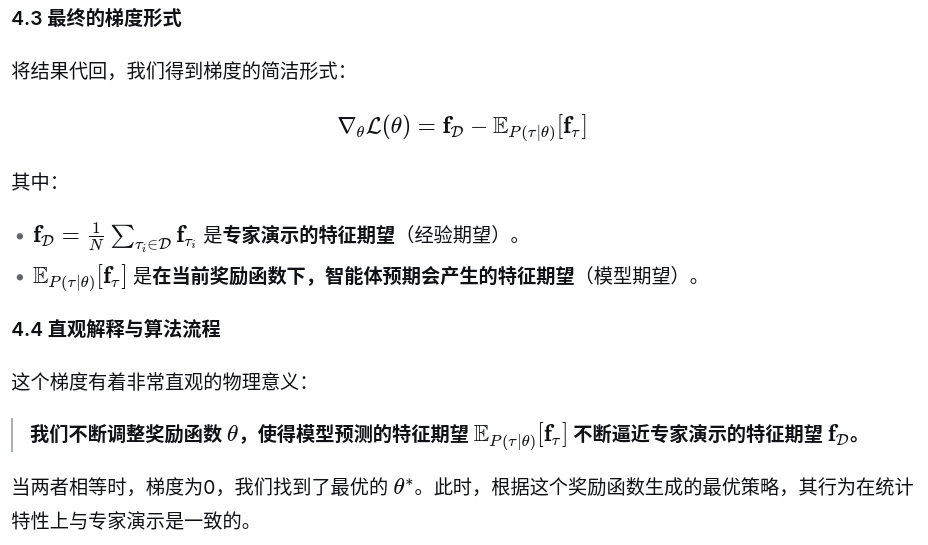  
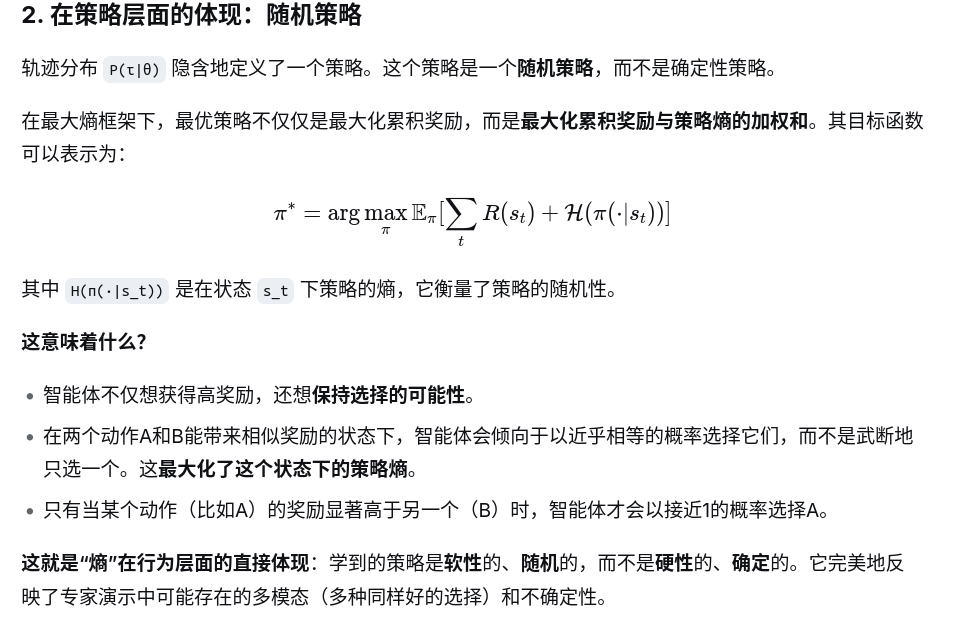